# Clasificación de imágenes con CNN + Variación de Hiperparámetros

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
import mlflow
import os
import matplotlib.pyplot as plt
import pandas as pd
import ast
import numpy as np
import seaborn as sns

In [4]:
class CNNClassifier(nn.Module):
	def __init__(self, input_size, dropout=0.0, num_classes=10, num_filters=[32, 64, 128]):
		super().__init__()
		self.features = nn.Sequential(
			nn.Conv2d(3, num_filters[0], 3, padding=1, padding_mode="reflect"),
			nn.BatchNorm2d(num_filters[0]),
			nn.ReLU(),
			nn.MaxPool2d(2, 2),

			nn.Conv2d(num_filters[0], num_filters[1], 3, padding=1, padding_mode="reflect"),
			nn.BatchNorm2d(num_filters[1]),
			nn.ReLU(),
			nn.MaxPool2d(2, 2),

			nn.Conv2d(num_filters[1], num_filters[2], 3, padding=1, padding_mode="reflect"),
			nn.BatchNorm2d(num_filters[2]),
			nn.ReLU(),
			nn.MaxPool2d(2, 2),

			nn.Dropout(dropout),
		)
		self.classifier = nn.Sequential(
			nn.Flatten(),
			nn.Linear((input_size // 8) ** 2 * num_filters[2], 256),
			nn.ReLU(),
			nn.Dropout(dropout),
			nn.Linear(256, num_classes)
		)

	def forward(self, x):
		x = self.features(x)
		x = self.classifier(x)
		return x


In [5]:
train_dir = "../data/Split_smol/train"
val_dir = "../data/Split_smol/val"

train_transform = T.Compose([
	T.Resize((64, 64)),
	T.ToTensor(),
	T.Normalize(mean=(0.5,), std=(0.5,))
])

val_transform = T.Compose([
	T.Resize((64, 64)),
	T.ToTensor(),
	T.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)


In [6]:
# Entrenamiento y evaluación
def train_eval(model, optimizer, criterion, train_loader, val_loader, device, epochs=5):
	model.to(device)
	train_acc, val_acc = [], []
	for epoch in range(epochs):
		model.train()
		correct, total = 0, 0
		for x, y in train_loader:
			x, y = x.to(device), y.to(device)
			optimizer.zero_grad()
			output = model(x)
			loss = criterion(output, y)
			loss.backward()
			optimizer.step()
			preds = output.argmax(1)
			correct += (preds == y).sum().item()
			total += y.size(0)
		train_acc.append(correct / total)

		# Validación
		model.eval()
		correct, total = 0, 0
		with torch.no_grad():
			for x, y in val_loader:
				x, y = x.to(device), y.to(device)
				preds = model(x).argmax(1)
				correct += (preds == y).sum().item()
				total += y.size(0)
		val_acc.append(correct / total)
	return train_acc, val_acc


In [7]:
params = [
	{"lr": 1e-3, "dropout": 0.0, "optimizer": "adam", "batch_size": 32},
	{"lr": 1e-3, "dropout": 0.5, "optimizer": "adam", "batch_size": 32},
	{"lr": 1e-4, "dropout": 0.2, "optimizer": "sgd", "batch_size": 64},
	{"lr": 5e-4, "dropout": 0.3, "optimizer": "adam", "batch_size": 64},
	{"lr": 1e-3, "dropout": 0.2, "optimizer": "sgd", "batch_size": 32},
	{"lr": 5e-4, "dropout": 0.5, "optimizer": "sgd", "batch_size": 128},
	{"lr": 1e-4, "dropout": 0.0, "optimizer": "adam", "batch_size": 128},
	{"lr": 1e-3, "dropout": 0.3, "optimizer": "adam", "batch_size": 128},
]

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []
EPOCHS = 20

for i, p in enumerate(params):
	print(f"Probando config {i+1}/{len(params)}: {p}")
	model = CNNClassifier(64, dropout=p["dropout"], num_classes=len(train_dataset.classes))

	if p["optimizer"] == "adam":
		optimizer = optim.Adam(model.parameters(), lr=p["lr"])
	else:
		optimizer = optim.SGD(model.parameters(), lr=p["lr"], momentum=0.9)

	train_loader = DataLoader(train_dataset, batch_size=p["batch_size"], shuffle=True)
	val_loader = DataLoader(val_dataset, batch_size=p["batch_size"])

	train_acc, val_acc = train_eval(model, optimizer, nn.CrossEntropyLoss(), train_loader, val_loader, device, epochs=EPOCHS)

	results.append({
		"dropout": p["dropout"],
		"lr": p["lr"],
		"opt": p["optimizer"],
		"batch": p["batch_size"],
		"train_acc": train_acc,
		"val_acc": val_acc
	})

Probando config 1/8: {'lr': 0.001, 'dropout': 0.0, 'optimizer': 'adam', 'batch_size': 32}
Probando config 2/8: {'lr': 0.001, 'dropout': 0.5, 'optimizer': 'adam', 'batch_size': 32}
Probando config 3/8: {'lr': 0.0001, 'dropout': 0.2, 'optimizer': 'sgd', 'batch_size': 64}
Probando config 4/8: {'lr': 0.0005, 'dropout': 0.3, 'optimizer': 'adam', 'batch_size': 64}
Probando config 5/8: {'lr': 0.001, 'dropout': 0.2, 'optimizer': 'sgd', 'batch_size': 32}
Probando config 6/8: {'lr': 0.0005, 'dropout': 0.5, 'optimizer': 'sgd', 'batch_size': 128}
Probando config 7/8: {'lr': 0.0001, 'dropout': 0.0, 'optimizer': 'adam', 'batch_size': 128}
Probando config 8/8: {'lr': 0.001, 'dropout': 0.3, 'optimizer': 'adam', 'batch_size': 128}


In [12]:
df = pd.DataFrame(results)
df.to_csv("results/resultados_hp.csv", index=False)

_df = df.copy()
_df["train_acc"] = _df["train_acc"].apply(lambda x: x[-1] if isinstance(x, list) else x)
_df["val_acc"] = _df["val_acc"].apply(lambda x: x[-1] if isinstance(x, list) else x)
_df

,dropout,lr,opt,batch,train_acc,val_acc
0,0.0,0.0010,adam,32,0.981349,0.618785
1,0.5,0.0010,adam,32,0.812052,0.662983
2,0.2,0.0001,sgd,64,0.619799,0.524862
3,0.3,0.0005,adam,64,0.975610,0.723757
4,0.2,0.0010,sgd,32,0.981349,0.718232
5,0.5,0.0005,sgd,128,0.639885,0.563536
6,0.0,0.0001,adam,128,0.989957,0.679558
7,0.3,0.0010,adam,128,0.855093,0.657459


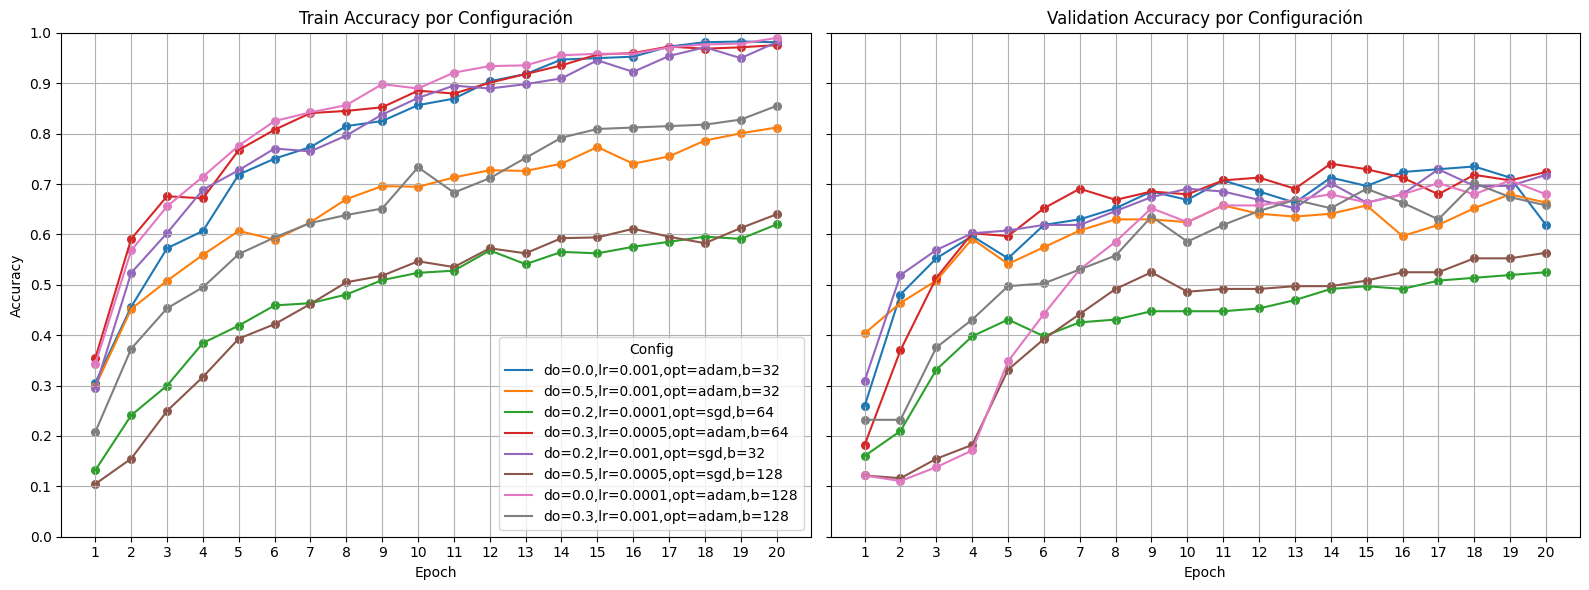

In [13]:
for col in ["train_acc", "val_acc"]:
	df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df["combo"] = df.apply(lambda row: f"do={row['dropout']},lr={row['lr']},opt={row['opt']},b={row['batch']}", axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
epochs = range(1, EPOCHS + 1)

# Train
for idx, row in df.iterrows():
	axes[0].plot(epochs, row["train_acc"], label=row["combo"])
	axes[0].scatter(epochs, row["train_acc"], s=30)
axes[0].set_title("Train Accuracy por Configuración")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0, 1)
axes[0].set_yticks([i/10 for i in range(11)])
axes[0].set_xticks(epochs)
axes[0].grid(True)
# axes[0].legend(title="Config", bbox_to_anchor=(1.025, 1), loc='upper left')
axes[0].legend(title="Config")

# Validation
for idx, row in df.iterrows():
	axes[1].plot(epochs, row["val_acc"], label=row["combo"])
	axes[1].scatter(epochs, row["val_acc"], s=30)
axes[1].set_title("Validation Accuracy por Configuración")
axes[1].set_xlabel("Epoch")
axes[1].set_ylim(0, 1)
axes[1].set_yticks([i/10 for i in range(11)])
axes[1].set_xticks(epochs)
axes[1].grid(True)
axes[1].get_legend().remove() if axes[1].get_legend() else None

plt.tight_layout()
plt.show()
fig.savefig("img/hp_results.png", dpi=300, bbox_inches='tight')

In [17]:
# Ordenar por validation accuracy
best_configs = _df.sort_values("val_acc", ascending=False)
print("Top 3 configuraciones por validation accuracy:")
print(best_configs[["dropout", "lr", "opt", "batch", "val_acc", "train_acc"]].head(3))

# Seleccionar la mejor configuración
best_config = best_configs.iloc[0]
BEST_LR = best_config['lr']
BEST_DROPOUT = best_config['dropout']
BEST_BATCH_SIZE = best_config['batch']

Top 3 configuraciones por validation accuracy:
   dropout      lr   opt  batch   val_acc  train_acc
3      0.3  0.0005  adam     64  0.723757   0.975610
4      0.2  0.0010   sgd     32  0.718232   0.981349
6      0.0  0.0001  adam    128  0.679558   0.989957


In [18]:
class CNNClassifierComplete(nn.Module):
	def __init__(self, input_size, dropout=0.0, num_classes=10, num_filters=[32, 64, 128], 
				 activation='relu'):
		super().__init__()
		
		# Función de activación
		if activation == 'leaky_relu':
			self.activation = nn.LeakyReLU(0.01)
		elif activation == 'swish':
			self.activation = nn.SiLU()  # Swish
		elif activation == 'gelu':
			self.activation = nn.GELU()
		else:
			self.activation = nn.ReLU()

		self.conv1 = nn.Sequential(
			nn.Conv2d(3, num_filters[0], 3, padding=1, padding_mode="reflect"),
			nn.BatchNorm2d(num_filters[0]),
			self.activation,
			nn.MaxPool2d(2, 2)
		)
		self.conv2 = nn.Sequential(
			nn.Conv2d(num_filters[0], num_filters[1], 3, padding=1, padding_mode="reflect"),
			nn.BatchNorm2d(num_filters[1]),
			self.activation,
			nn.MaxPool2d(2, 2)
		)
		self.conv3 = nn.Sequential(
			nn.Conv2d(num_filters[1], num_filters[2], 3, padding=1, padding_mode="reflect"),
			nn.BatchNorm2d(num_filters[2]),
			self.activation,
			nn.MaxPool2d(2, 2)
		)
		
		self.features = nn.Sequential(
			self.conv1,
			self.conv2,
			self.conv3,
			nn.Dropout(dropout),
		)
		
		self.classifier = nn.Sequential(
			nn.Flatten(),
			nn.Linear((input_size // 8) ** 2 * num_filters[2], 256),
			self.activation,
			nn.Dropout(dropout),
			nn.Linear(256, num_classes)
		)

	def forward(self, x):
		x = self.features(x)
		x = self.classifier(x)
		return x

In [19]:
augmentation_configs = {
	'base': T.Compose([
		T.Resize((64, 64)),
		T.ToTensor(),
		T.Normalize(mean=(0.5,), std=(0.5,))
	]),

	'medium': T.Compose([
		T.Resize((72, 72)),
		T.RandomCrop((64, 64)),
		T.RandomHorizontalFlip(p=0.5),
		T.RandomRotation(degrees=10),
		T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
		T.ToTensor(),
		T.Normalize(mean=(0.5,), std=(0.5,))
	]),

	'heavy': T.Compose([
		T.Resize((80, 80)),
		T.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.33)),
		T.RandomHorizontalFlip(p=0.5),
		T.RandomVerticalFlip(p=0.3),
		T.RandomRotation(degrees=15),
		T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
		T.RandomGrayscale(p=0.1),
		T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.2),
		T.ToTensor(),
		T.Normalize(mean=(0.5,), std=(0.5,))
	])
}

In [20]:
experimental_configs = [
	{'aug': 'base', 'activation': 'relu'},
	{'aug': 'medium', 'activation': 'relu'},
	{'aug': 'heavy', 'activation': 'relu'},
	{'aug': 'medium', 'activation': 'leaky_relu'},
	{'aug': 'medium', 'activation': 'swish'},
	{'aug': 'medium', 'activation': 'gelu'},
]

In [21]:
def train_eval_complete(model, optimizer, criterion, train_loader, val_loader, device, epochs=20, scheduler=None):
	model.to(device)
	train_acc, val_acc, train_loss, val_loss = [], [], [], []
	
	for epoch in range(epochs):
		# Training
		model.train()
		correct, total, running_loss = 0, 0, 0.0
		for x, y in train_loader:
			x, y = x.to(device), y.to(device)
			optimizer.zero_grad()
			output = model(x)
			loss = criterion(output, y)
			loss.backward()
			optimizer.step()
			
			preds = output.argmax(1)
			correct += (preds == y).sum().item()
			total += y.size(0)
			running_loss += loss.item()
			
		train_acc.append(correct / total)
		train_loss.append(running_loss / len(train_loader))
		
		# Validation
		model.eval()
		correct, total, running_loss = 0, 0, 0.0
		with torch.no_grad():
			for x, y in val_loader:
				x, y = x.to(device), y.to(device)
				output = model(x)
				loss = criterion(output, y)
				preds = output.argmax(1)
				correct += (preds == y).sum().item()
				total += y.size(0)
				running_loss += loss.item()
				
		val_acc.append(correct / total)
		val_loss.append(running_loss / len(val_loader))
		
		if scheduler:
			scheduler.step()
			
		# Print progress every 5 epochs
		if (epoch + 1) % 5 == 0:
			print(f"  Epoch {epoch+1:2d}/{epochs}: Train: {train_acc[-1]:.4f} | Val: {val_acc[-1]:.4f} | Train Loss: {train_loss[-1]:.4f}")
	
	return train_acc, val_acc, train_loss, val_loss

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
advanced_results = []

print(f"Iniciando en {device}")
print(f"Modelo: lr={BEST_LR}, dropout={BEST_DROPOUT}, batch_size={BEST_BATCH_SIZE}, epochs={EPOCHS}")
print("="*80)

for i, config in enumerate(experimental_configs):
	print(f"\nExperimento {i+1}/{len(experimental_configs)}:")
	print(f"Aug: {config['aug']}, Activation: {config['activation']}")
	
	train_transform = augmentation_configs[config['aug']]
	train_dataset_exp = ImageFolder(train_dir, transform=train_transform)
	val_dataset_exp = ImageFolder(val_dir, transform=val_transform)
	train_loader = DataLoader(train_dataset_exp, batch_size=int(BEST_BATCH_SIZE), shuffle=True)
	val_loader = DataLoader(val_dataset_exp, batch_size=int(BEST_BATCH_SIZE))
	
	model = CNNClassifierComplete(
		input_size=64, 
		dropout=BEST_DROPOUT, 
		num_classes=len(train_dataset.classes),
		activation=config['activation'],
	)
	
	optimizer = optim.Adam(model.parameters(), lr=BEST_LR)
	scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
	criterion = nn.CrossEntropyLoss()
	
	train_acc, val_acc, train_loss, val_loss = train_eval_complete(
		model, optimizer, criterion, train_loader, val_loader, device, 
		epochs=EPOCHS, scheduler=scheduler
	)
	
	result = {
		'augmentation': config['aug'],
		'activation': config['activation'],
		'train_acc': train_acc,
		'val_acc': val_acc,
		'train_loss': train_loss,
		'val_loss': val_loss,
		'final_val_acc': val_acc[-1],
		'final_train_acc': train_acc[-1],
		'max_val_acc': max(val_acc),
		'max_val_epoch': val_acc.index(max(val_acc)) + 1
	}
	
	advanced_results.append(result)
	
	print(f"Final Val Acc: {val_acc[-1]:.4f}, Max Val Acc: {max(val_acc):.4f} (epoch {val_acc.index(max(val_acc))+1})")

Iniciando en cpu
Modelo: lr=0.0005, dropout=0.3, batch_size=64, epochs=20

Experimento 1/6:
Aug: base, Activation: relu
  Epoch  5/20: Train: 0.7862 | Val: 0.6133 | Train Loss: 0.6084
  Epoch 10/20: Train: 0.8910 | Val: 0.6685 | Train Loss: 0.2881
  Epoch 15/20: Train: 0.9670 | Val: 0.7017 | Train Loss: 0.1319
  Epoch 20/20: Train: 0.9813 | Val: 0.7072 | Train Loss: 0.0888
Final Val Acc: 0.7072, Max Val Acc: 0.7293 (epoch 18)

Experimento 2/6:
Aug: medium, Activation: relu
  Epoch  5/20: Train: 0.5093 | Val: 0.4972 | Train Loss: 1.2549
  Epoch 10/20: Train: 0.5983 | Val: 0.5359 | Train Loss: 1.0364
  Epoch 15/20: Train: 0.6643 | Val: 0.5801 | Train Loss: 0.8696
  Epoch 20/20: Train: 0.7059 | Val: 0.6022 | Train Loss: 0.8036
Final Val Acc: 0.6022, Max Val Acc: 0.6298 (epoch 17)

Experimento 3/6:
Aug: heavy, Activation: relu
  Epoch  5/20: Train: 0.3730 | Val: 0.4751 | Train Loss: 1.6401
  Epoch 10/20: Train: 0.4648 | Val: 0.4917 | Train Loss: 1.4289
  Epoch 15/20: Train: 0.5265 | Val: 0

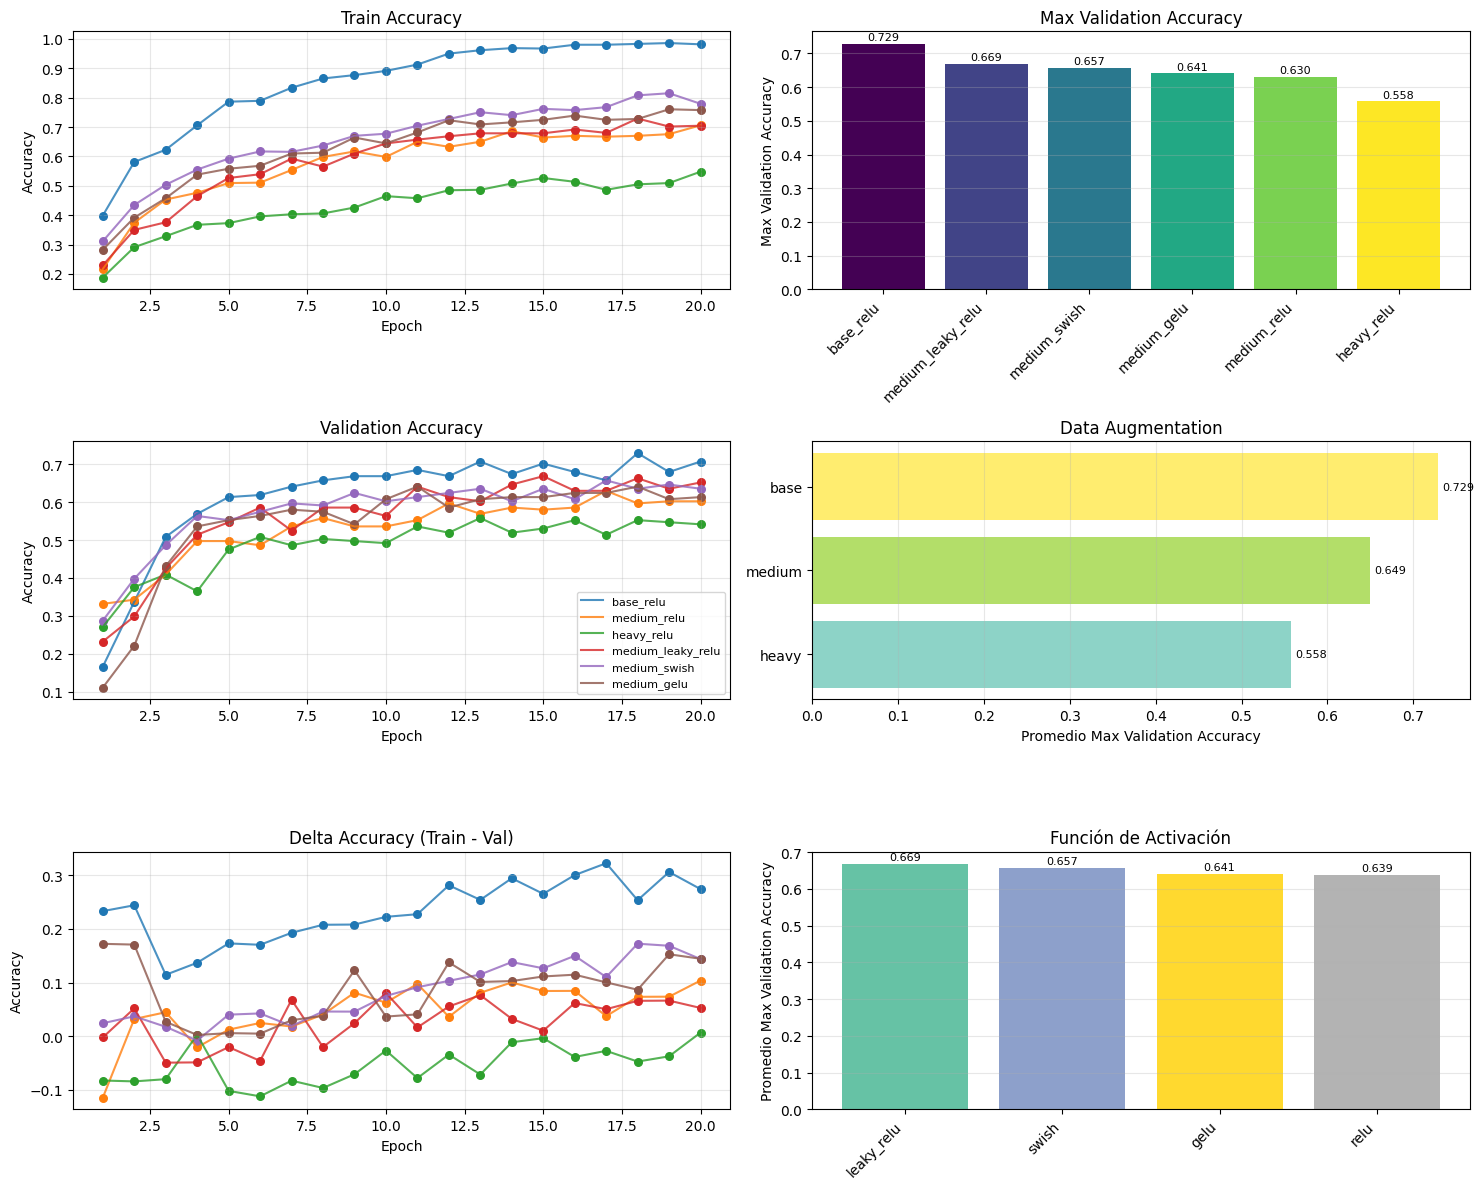

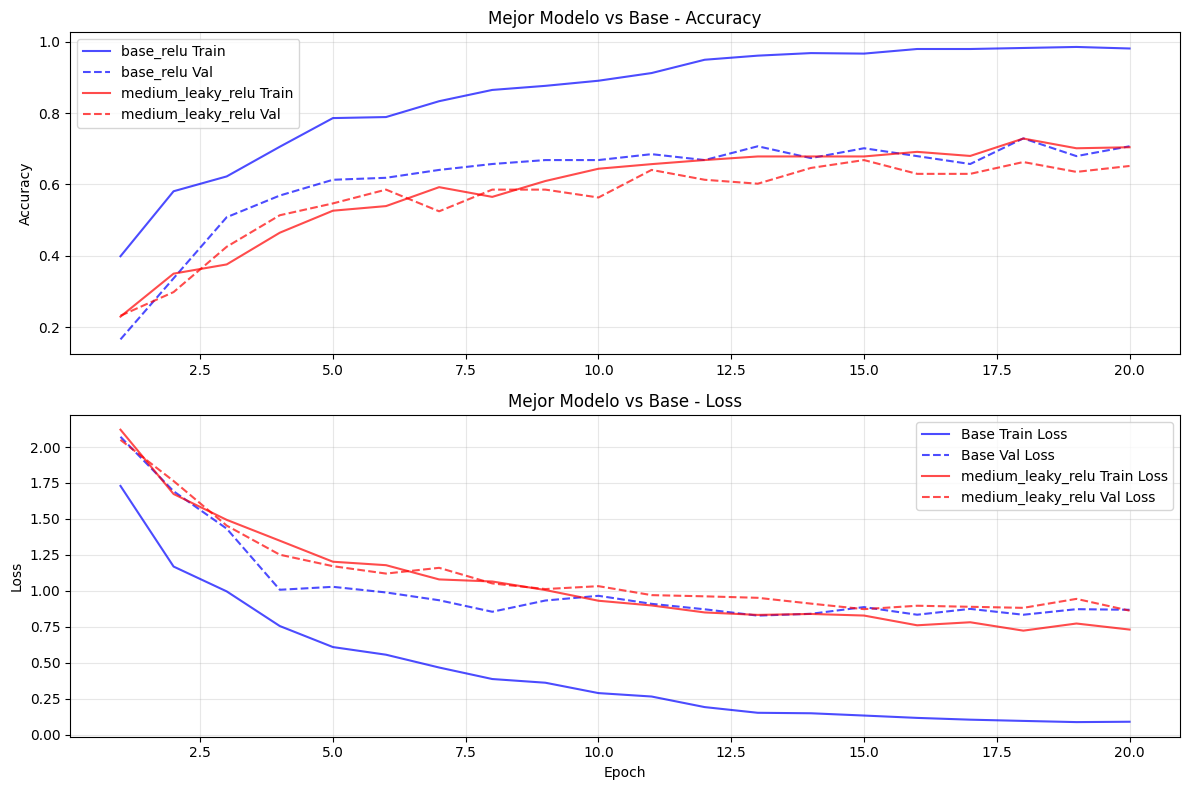

In [ ]:
advanced_df = pd.DataFrame(advanced_results)
advanced_df['name'] = advanced_df.apply(lambda row: f"{row['augmentation']}_{row['activation']}", axis=1)
advanced_df.to_csv("results/advanced_results.csv", index=False)
ranking = advanced_df.sort_values('max_val_acc', ascending=False)

plt.style.use('default')
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
epochs = range(1, EPOCHS + 1)

# Train Accuracy
ax1 = axes[0, 0]
for _, row in advanced_df.iterrows():
	ax1.plot(epochs, row['train_acc'], label=row['name'], alpha=0.8)
	ax1.scatter(epochs, row["train_acc"], s=30)
ax1.set_title('Train Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
# ax1.legend(bbox_to_anchor=(1.025, 1), loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# Validation Accuracy
ax2 = axes[1, 0]
for _, row in advanced_df.iterrows():
	ax2.plot(epochs, row['val_acc'], label=row['name'], alpha=0.8)
	ax2.scatter(epochs, row["val_acc"], s=30)
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# Delta Accuracy
ax3 = axes[2, 0]
for _, row in advanced_df.iterrows():
	train_acc = np.array(row['train_acc'])
	val_acc = np.array(row['val_acc'])
	delta_acc = train_acc - val_acc
	ax3.plot(epochs, delta_acc, label=row['name'], alpha=0.8)
	ax3.scatter(epochs, delta_acc, s=30)
ax3.set_title('Delta Accuracy (Train - Val)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
# ax3.legend(bbox_to_anchor=(1.025, 1), loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3)

# Max Accuracy
ax4 = axes[0, 1]
bars4 = ax4.bar(range(len(ranking)), ranking['max_val_acc'], 
			   color=plt.cm.viridis(np.linspace(0, 1, len(ranking))))
ax4.set_title('Max Validation Accuracy')
ax4.set_ylabel('Max Validation Accuracy')
ax4.set_xticks(range(len(ranking)))
ax4.set_xticklabels(ranking['name'], rotation=45, ha='right')
ax4.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars4, ranking['max_val_acc']):
	height = bar.get_height()
	ax4.text(bar.get_x() + bar.get_width()/2., height + 0.005,
			 f'{val:.3f}', ha='center', va='bottom', fontsize=8)

# Data Augmentation
ax5 = axes[1, 1]
aug_comparison = advanced_df.groupby('augmentation')['max_val_acc'].mean().sort_values(ascending=True)
bars5 = ax5.barh(range(len(aug_comparison)), aug_comparison.values, 
				 color=plt.cm.Set3(np.linspace(0, 1, len(aug_comparison))))
ax5.set_title('Data Augmentation')
ax5.set_xlabel('Promedio Max Validation Accuracy')
ax5.set_yticks(range(len(aug_comparison)))
ax5.set_yticklabels(aug_comparison.index)
ax5.grid(True, alpha=0.3, axis='x')
for bar, val in zip(bars5, aug_comparison.values):
	width = bar.get_width()
	ax5.text(width + 0.005, bar.get_y() + bar.get_height()/2.,
			 f'{val:.3f}', ha='left', va='center', fontsize=8)

# Función de Activación
ax6 = axes[2, 1]
act_comparison = advanced_df.groupby('activation')['max_val_acc'].mean().sort_values(ascending=False)
bars6 = ax6.bar(range(len(act_comparison)), act_comparison.values,
				color=plt.cm.Set2(np.linspace(0, 1, len(act_comparison))))
ax6.set_title('Función de Activación')
ax6.set_ylabel('Promedio Max Validation Accuracy')
ax6.set_xticks(range(len(act_comparison)))
ax6.set_xticklabels(act_comparison.index, rotation=45, ha='right')
ax6.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars6, act_comparison.values):
	height = bar.get_height()
	ax6.text(bar.get_x() + bar.get_width()/2., height + 0.005,
			 f'{val:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
fig.savefig('img/advanced_results_analysis.png', dpi=300, bbox_inches='tight')

# Mejor modelo vs base
fig = plt.figure(figsize=(12, 8))
base_idx = advanced_df[advanced_df['name'] == 'base_relu'].index[0]
best_idx = ranking.index[1]

base_data = advanced_df.iloc[base_idx]
best_data = advanced_df.iloc[best_idx]

plt.subplot(2, 1, 1)
plt.plot(epochs, base_data['train_acc'], 'b-', label='base_relu Train', alpha=0.7)
plt.plot(epochs, base_data['val_acc'], 'b--', label='base_relu Val', alpha=0.7) 
plt.plot(epochs, best_data['train_acc'], 'r-', label=f'{best_data["name"]} Train', alpha=0.7)
plt.plot(epochs, best_data['val_acc'], 'r--', label=f'{best_data["name"]} Val', alpha=0.7)
plt.title('Mejor Modelo vs Base - Accuracy')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(epochs, base_data['train_loss'], 'b-', label='Base Train Loss', alpha=0.7)
plt.plot(epochs, base_data['val_loss'], 'b--', label='Base Val Loss', alpha=0.7)
plt.plot(epochs, best_data['train_loss'], 'r-', label=f'{best_data["name"]} Train Loss', alpha=0.7)
plt.plot(epochs, best_data['val_loss'], 'r--', label=f'{best_data["name"]} Val Loss', alpha=0.7)
plt.title('Mejor Modelo vs Base - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
fig.savefig('img/best_vs_base.png', dpi=300, bbox_inches='tight')